# Parameter tuning

While some analytic solutions exist for choosing the right free parameter for your model, it is hardly the case that you'll be able to compute it as datasets get large. 

In this demo we'll go over 3 variations of cross-validation for optimizing the free parameters for your models. The procedure is very similar to the optimization we did for $\lambda$ in Ridge and LASSO.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Let's use synthetic data as we always do, but in this case we create it in high dimensions so we can't easily visualize it.

In [2]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

# make a linearly separable dataset
X, y = make_classification(n_features=20, 
                           n_redundant=0, 
                           n_informative=2,
                           random_state=1, 
                           n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

## Cross Validation

Let's use K-fold cross validation to optimize K for a K-nn classifier.

In [3]:
from sklearn.model_selection import KFold
n_folds = 5
kf = KFold(n_folds)  # 5 fold classification... just because.

In [4]:
candidate_ks = np.arange(1, 10)  # test k from 1 to 9

from sklearn.neighbors import KNeighborsClassifier
scores = []
for k in candidate_ks:
    this_k_scores = []
    for train, test in kf.split(X):
        this_knn = KNeighborsClassifier(k)
        this_knn.fit(X[train], y[train])
        this_k_scores.append(this_knn.score(X[test], y[test]))
            
    # this can be done in one line! see if you can figure this out.
#     this_fold_scores = [KNeighborsClassifier(k).fit(X[train], y[train]).score(X[test], y[test]) for k in candidate_ks]
    
    scores.append(this_k_scores)

scores = np.array(scores)
k_scores = scores.mean(axis=1)
scores.shape

(9, 5)

Text(0.5,1,'Best K: 7')

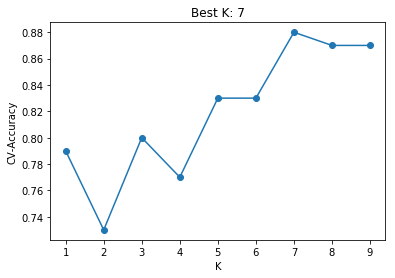

In [5]:
plt.plot(candidate_ks, k_scores, 'o-')
plt.ylabel("CV-Accuracy")
plt.xlabel("K")
best_k = candidate_ks[np.argmax(k_scores)]
plt.title("Best K: {}".format(best_k))

## Cross_val_score
Scikit-learn includes a function, cross_val_score that functions identically to the code above, except optimized for use with their classifiers. We'll use it to optimize the number of trees in random forest.

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

n_folds = 5
kf = KFold(n_folds)  # 5 fold classification... just because.


max_depth=5  # a nested for loop can be run to optimize this too

candidate_trees = np.arange(1, 100)
scores = []
for n_trees in candidate_trees:
    # we specify the max depth of each tree, as well as set the number of trees in our random forest
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_trees, max_features=1)
    scores.append(cross_val_score(clf, X, y, cv=kf))

scores = np.array(scores)
tree_scores = scores.mean(axis=1)

Text(0.5,1,'Best N-trees: 73')

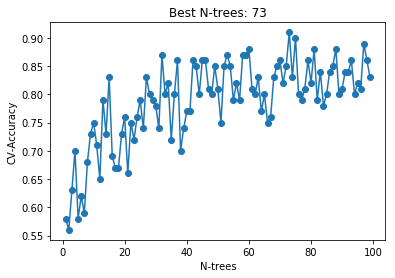

In [7]:
plt.plot(candidate_trees, tree_scores, 'o-')
plt.ylabel("CV-Accuracy")
plt.xlabel("N-trees")
best_k = candidate_trees[np.argmax(tree_scores)]
plt.title("Best N-trees: {}".format(best_k))

## Grid search
If you have the time and computing power, or if you are building a high consequence model, you can run a grid search that iterates through every combination of parameters in your search space.

We'll use this to optimize the two free parameters, $\gamma$ and $C$ or $\nu$ (nu) in  an RBF-SVM (because this won't kill your computer to run).

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# grid of parameters to be tested (can also be a list)
param_grid = {"C": np.logspace(-3, 3, 10), 
              "gamma": np.logspace(-3, 3, 10)}

# classifier to be tested
clf = SVC(kernel="rbf")

# create a grid object with 5 fold CV, testing the parameters above
grid = GridSearchCV(clf, cv=kf, param_grid=param_grid)

# fit the object
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 4.64159e-03, 2.15443e-02, 1.00000e-01, 4.64159e-01,
       2.15443e+00, 1.00000e+01, 4.64159e+01, 2.15443e+02, 1.00000e+03]), 'gamma': array([1.00000e-03, 4.64159e-03, 2.15443e-02, 1.00000e-01, 4.64159e-01,
       2.15443e+00, 1.00000e+01, 4.64159e+01, 2.15443e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [9]:
# if you're not interested in what's going on under the hood...
grid.best_params_

{'C': 215.44346900318823, 'gamma': 0.004641588833612777}

In [10]:
# grid has a number of results
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

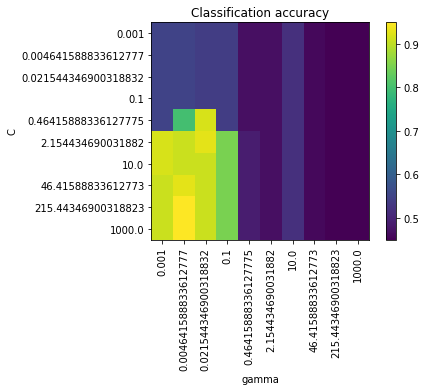

In [11]:
plt.imshow(grid.cv_results_["mean_test_score"].reshape(10, 10))
plt.xticks(np.arange(10), np.logspace(-3, 3, 10), rotation="vertical")
plt.xlabel("gamma")
plt.yticks(np.arange(10), np.logspace(-3, 3, 10))
plt.ylabel("C")
plt.title("Classification accuracy")
plt.colorbar()

In [12]:
grid.cv_results_["params"]

[{'C': 0.001, 'gamma': 0.001},
 {'C': 0.001, 'gamma': 0.004641588833612777},
 {'C': 0.001, 'gamma': 0.021544346900318832},
 {'C': 0.001, 'gamma': 0.1},
 {'C': 0.001, 'gamma': 0.46415888336127775},
 {'C': 0.001, 'gamma': 2.154434690031882},
 {'C': 0.001, 'gamma': 10.0},
 {'C': 0.001, 'gamma': 46.41588833612773},
 {'C': 0.001, 'gamma': 215.44346900318823},
 {'C': 0.001, 'gamma': 1000.0},
 {'C': 0.004641588833612777, 'gamma': 0.001},
 {'C': 0.004641588833612777, 'gamma': 0.004641588833612777},
 {'C': 0.004641588833612777, 'gamma': 0.021544346900318832},
 {'C': 0.004641588833612777, 'gamma': 0.1},
 {'C': 0.004641588833612777, 'gamma': 0.46415888336127775},
 {'C': 0.004641588833612777, 'gamma': 2.154434690031882},
 {'C': 0.004641588833612777, 'gamma': 10.0},
 {'C': 0.004641588833612777, 'gamma': 46.41588833612773},
 {'C': 0.004641588833612777, 'gamma': 215.44346900318823},
 {'C': 0.004641588833612777, 'gamma': 1000.0},
 {'C': 0.021544346900318832, 'gamma': 0.001},
 {'C': 0.02154434690031883